# AHRS Filter/Fusion Viewer

## Load raw sensor data
To view different data, change the path in "data_source" to a folder containing your data. Refer to the CSV files within the "sample_data" folder for expected format.

In [1]:
%config IPCompleter.greedy=True
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import math

data_source = "./sample_data"
NUM_HEADER_LINES = 4 # number of header lines in the file

time_scale = 0.000000001 # nanoseconds to seconds
accel_scale = 1.0
gyro_scale = 0.01745329251994329576923690768489 # degrees to radians
magn_scale = 1.0

correction_vec = np.array([
    0,
    0.0, 0.0, 0.0, # accelerometer x,y,z corrections
    -0.035, -0.018, -0.015, # gyro x,y,z corrections
    0.0, 0.0, 0.0 # magnetometer x,y,z corrections
])

scale_vec = np.array([
    time_scale,
    accel_scale, accel_scale, accel_scale,
    gyro_scale, gyro_scale, gyro_scale,
    magn_scale, magn_scale, magn_scale
])


data_list = {} # dictionary to hold our data sets / file names

# Loop through our files to parse data
for root, dirs, files in os.walk(data_source, topdown=False):
    for name in files:
        # Fill in our array
        unscaled_data = np.genfromtxt(os.path.join(root, name), delimiter=',', dtype='f4', 
                                          skip_header=NUM_HEADER_LINES, encoding='ascii')
        scaled_data = np.multiply(unscaled_data, scale_vec[None, :])
        data_list[name] = np.add(scaled_data, correction_vec[None, :])

## Filter & fuse the raw data

### Obtaining the initial orientation from 6-axis & 9-axis data

In [2]:
def quat_from_accel(accel):
    # Normalize accel data
    a_norm = np.linalg.norm(accel)
    if (a_norm == 0.0):
        return [1.0, 0.0, 0.0, 0.0] # invalid accel data, return base orientation
    a_hat = (accel / a_norm)
    
    # Get cross product of accel and z axis to obtain orthogonal vector
    z_hat = [0.0, 0.0, 1.0]
    orth_vec = np.cross(z_hat, a_hat)
    orth_norm = np.linalg.norm(orth_vec)
    if (orth_norm == 0.0):
        return [1.0, 0.0, 0.0, 0.0] # base orientation
    orth_hat = orth_vec / orth_norm
    
    # Get angle between accel and z axis
    theta = math.acos(np.dot(z_hat, a_hat))
    
    # Calculate quaternion orientation by rotation of theta about the orthogonal unit vector
    sin_over_2 = math.sin(theta) / 2.0
    quat = [
        (math.cos(theta) / 2.0),
        (-orth_hat[0] * sin_over_2),
        (-orth_hat[1] * sin_over_2),
        (-orth_hat[2] * sin_over_2)
    ]
    quat_norm = np.linalg.norm(quat)
    if (quat_norm == 0.0):
        return [1.0, 0.0, 0.0, 0.0] # error, return base orientation
    quat_hat = quat / quat_norm
    return quat_hat


print(quat_from_accel([1.0, 0.0, 1.00]))

[ 0.70710678 -0.         -0.70710678 -0.        ]


### Obtaining updated quaternion orientation from 6-axis data

In [3]:
def madgwick_update_6(quat_in, accel, gyro, delta_t, beta, zeta):
    # Normalize accel data
    a_norm = np.linalg.norm(accel)
    if (a_norm == 0.0):
        return quat_in # invalid accel data, return previous orientation   
    a_hat = (accel / a_norm)

    # Compute & normalize gradient
    gradient = compute_gradient_6(quat_in, a_hat)
    gradient_norm = np.linalg.norm(gradient)
    if (gradient_norm == 0.0):
        return quat_in # invalid gradient, return previous orientation
    gradient_hat = (gradient / gradient_norm)
    
    # Correct gyroscope measurement
    gyro_corrected = compute_gyro_corrected_6(quat_in, gradient_hat, gyro, delta_t, zeta)
    
    # Compute q dot, update quaternion
    q_dot = compute_q_dot_6(quat_in, gradient_hat, gyro_corrected, beta)
    quat = [(quat_i + (q_dot_i * delta_t)) for quat_i, q_dot_i in zip(quat_in, q_dot)]
    quat_norm = np.linalg.norm(quat)
    if (quat_norm == 0.0):
        return quat_in # invalid update, return previous orientation
    
    return (quat / quat_norm)

# Helper functions
def compute_gradient_6(quat, a_hat):
    # Compute the objective function and jacobian
    obj_1 = (2.0 * quat[1] * quat[3]) - (2.0 * quat[0] * quat[2]) - a_hat[0]
    obj_2 = (2.0 * quat[0] * quat[1]) - (2.0 * quat[2] * quat[3]) - a_hat[1]
    obj_3 = 1.0 - (2.0 * (quat[1] ** 2)) - (2.0 * (quat[2] ** 2)) - a_hat[2]
    
    j_11_and_24 = 2.0 * quat[2]
    j_12_and_23 = 2.0 * quat[3]
    j_13_and_22 = 2.0 * quat[0]
    j_14_and_21 = 2.0 * quat[1]
    j_32 = 4.0 * quat[1]
    j_33 = 4.0 * quat[2]
    
    gradient = [
        (j_14_and_21 * obj_2) - (j_11_and_24 * obj_1),
        (j_12_and_23 * obj_1) + (j_13_and_22 * obj_2) - (j_32 * obj_3),
        (j_12_and_23 * obj_2) - (j_33 * obj_3) - (j_13_and_22 * obj_1),
        (j_14_and_21 * obj_1) + (j_11_and_24 * obj_2)
    ]
    
    return gradient

def compute_corrected_gyro_6(quat, gradient_hat, gyro, delta_t, zeta):
    gyro_bias = [
        ((2.0 * quat[0] * gradiant_hat[1]) -
         (2.0 * quat[1] * gradient_hat[0]) -
         (2.0 * quat[2] * gradient_hat[3]) +
         (2.0 * quat[3] * gradient_hat[2])),
        
        ((2.0 * quat[0] * gradiant_hat[2]) +
         (2.0 * quat[1] * gradient_hat[3]) -
         (2.0 * quat[2] * gradient_hat[0]) -
         (2.0 * quat[3] * gradient_hat[1])),
        
        ((2.0 * quat[0] * gradiant_hat[3]) -
         (2.0 * quat[1] * gradient_hat[2]) +
         (2.0 * quat[2] * gradient_hat[1]) -
         (2.0 * quat[3] * gradient_hat[0]))
    ]
    return [(gyro_i - (bias_i * delta_t * zeta)) for gyro_i, bias_i in zip(gyro, gyro_bias)]

def compute_q_dot_6(quat, gradient_hat, gyro_corrected, beta):    
    q_dot = [
        -((0.5 * quat[1] * gyro_corrected[0]) -
          (0.5 * quat[2] * gyro_corrected[1]) -
          (0.5 * quat[3] * gyro_corrected[2]) -
          (gradient_hat[0] * beta)),
        
        ((0.5 * quat[0] * gyro_corrected[0]) +
          (0.5 * quat[2] * gyro_corrected[1]) -
          (0.5 * quat[3] * gyro_corrected[2]) -
          (gradient_hat[1] * beta)),
        
        ((0.5 * quat[0] * gyro_corrected[0]) -
          (0.5 * quat[1] * gyro_corrected[1]) +
          (0.5 * quat[3] * gyro_corrected[2]) -
          (gradient_hat[2] * beta)),
        
        ((0.5 * quat[0] * gyro_corrected[0]) +
          (0.5 * quat[1] * gyro_corrected[1]) -
          (0.5 * quat[2] * gyro_corrected[2]) -
          (gradient_hat[3] * beta))        
    ]
    
    return q_dot

### Obtaining updated quaternion orientation from 9-axis data

In [4]:
def madgwick_update_9():
    pass

### Running filter/fusion on the 6-axis, 9-axis data

## Plot the raw data

<IPython.core.display.Javascript object>


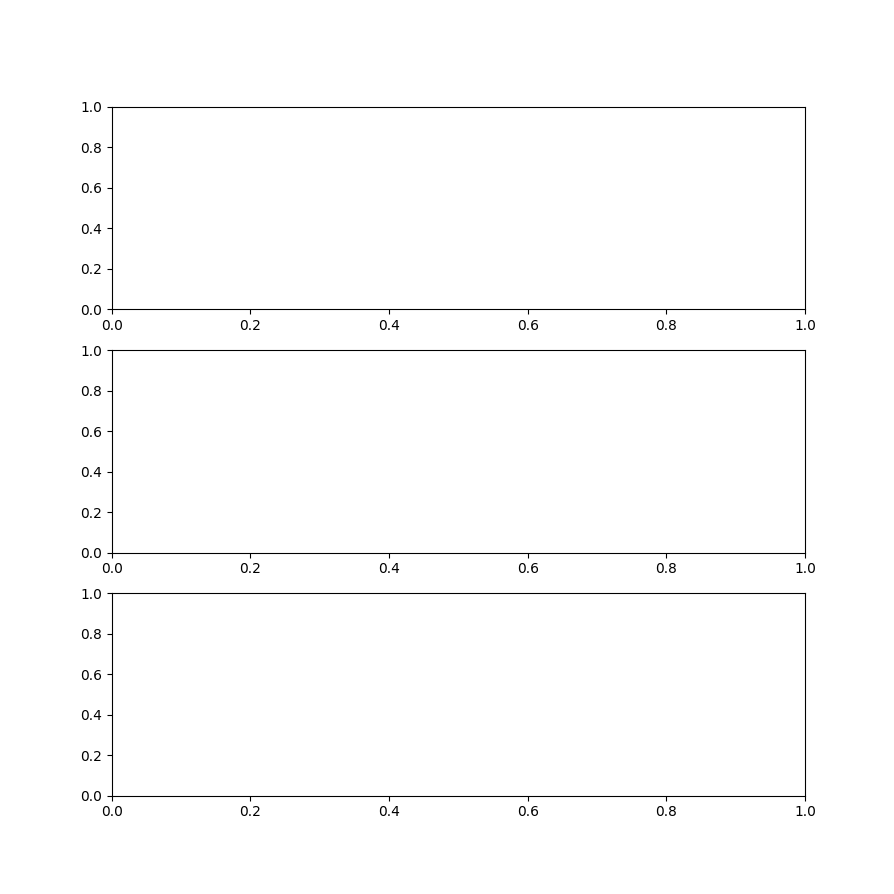

In [5]:
# Setup figure
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['lines.linewidth'] = 0.5
unfiltered_fig = plt.figure()
# Setup individual plots
unfiltered_axes = []
unfiltered_axes.append(unfiltered_fig.add_subplot(3,1,1))
unfiltered_axes.append(unfiltered_fig.add_subplot(3,1,2))
unfiltered_axes.append(unfiltered_fig.add_subplot(3,1,3))

# Data type will be selected via a single selection list
# we'll use a dictionary to keep track of each column and it's data type
data_type_columns = {'Accelerometer' : [1, 2, 3], 'Gyroscope' : [4, 5, 6], 'Magnetometer' : [7, 8, 9]}
data_type_select = widgets.Select(
    options = data_type_columns.keys(),
    description = 'Data type',
    disabled = False,
    layout = widgets.Layout(width = "300px")           
)

# Data sets will be selected via a multiple selection list
unfiltered_data_select = widgets.SelectMultiple(
    options= data_list.keys(),
    description='Data sets',
    disabled = False,
    layout = widgets.Layout(width = "300px")
)

# Update plots button
update_plots_btn = widgets.Button(
    description="Update plots",
    disabled = False,
    layout = widgets.Layout(margin = "10px 0 20px 90px", border = "1px solid gray")
)

def update_plots(b):
    # Clear out old lines
    for ax in unfiltered_axes:
        ax.cla()
        
    # For each data set selected
    for item in unfiltered_data_select.value:
        # Iterator to plot to the correct graph
        i = 0
        # For each column representing the data type
        for column in data_type_columns[data_type_select.value]:
            unfiltered_axes[i].plot(data_list[item][:,0], data_list[item][:,column])
            i += 1
            
    unfiltered_fig.show()
    
update_plots_btn.on_click(update_plots)

# Display our widgets
widgets.VBox([update_plots_btn, widgets.HBox([data_type_select, unfiltered_data_select])])